In [43]:
import numpy as np
import random
from matplotlib import pyplot as plt
from numba import jit

In [44]:
data = np.loadtxt('../data/TSPA.csv', delimiter=';').astype(np.int16)
data.shape

(200, 3)

In [45]:
def distance(xa, ya, xb, yb):
    return round(((xa-xb)**2+(ya-yb)**2)**(1/2))
distance(1,2,4,5)

4

In [46]:
def create_cost_matrix(data):
    distance_matrix = np.empty((0,len(data)), int)
    for i in range(len(data)):
        row = []
        for j in range(len(data)):
            if i != j:
                row.append(distance(data[i][0], data[i][1], data[j][0], data[j][1]))
            else:
                row.append(0)
        distance_matrix = np.append(distance_matrix, [row], axis=0)

    costs = data[:,2]
    #print(distance_matrix)
    cost_matrix = (distance_matrix + costs)
    return cost_matrix

cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

In [47]:
cost_matrix

array([[  84, 2032, 2098, ..., 4159, 3783, 1514],
       [1633,  483, 2398, ..., 3349, 2266,  817],
       [ 720, 1419, 1462, ..., 3640, 3149,  964],
       ...,
       [2782, 2371, 3641, ..., 1461, 2908, 2554],
       [2558, 1440, 3302, ..., 3060, 1309, 1773],
       [1234,  936, 2062, ..., 3651, 2718,  364]])

In [48]:
def random_solution(cost_matrix, limit=100):
    random_solution_list = list(range(0,len(cost_matrix)))
    random.shuffle(random_solution_list)
    return np.array(random_solution_list)[:limit]

solution = random_solution(cost_matrix, 100)
print(solution)

[ 77 145  53 125 175  88 163  33 133  42 152  22  31  79   6 141   5  68
   1 159  12  99 104 161 105  50 162   3  93 113 124 148 183 157 136 189
  91 178 115  47 143  83  89 191 167  35 190  96  81 123 184  29  66 169
 102  27  87 174 111 187   9 171  11 138  54 147  32 114  69  49  45 117
  78 188  73 126  86 128 198 118  76 176  70  85  41  44 103  65 165 146
  51 154 135 140 172  95  19  97  20  74]


In [49]:
def calculate_objective_function(solution, cost_matrix):
    obj_func = 0
    for i in range(len(solution)-1):
        obj_func += cost_matrix[solution[i], solution[i+1]]
    obj_func += cost_matrix[solution[-1], solution[0]]
    return obj_func

calculate_objective_function(solution, cost_matrix)

263567

In [50]:
def nearest_neighbour(cost_matrix, current_id=random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    while len(solution) < limit:
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    return np.array(solution)

solution = nearest_neighbour(cost_matrix)
print(calculate_objective_function(solution, cost_matrix))

88098


In [51]:
def greedy_cycle(cost_matrix, current_id = random.randint(0, len(cost_matrix)-1), limit=100):
    all_ids = set(list(range(0,len(cost_matrix))))
    all_ids.remove(current_id)
    solution = [current_id]
    
    for _ in range(1):
        min_val = 99999
        min_id = -1
        for next_id in all_ids:
            if cost_matrix[current_id][next_id] < min_val:
                min_val = cost_matrix[current_id][next_id]
                min_id = next_id
        solution.append(min_id)
        all_ids.remove(min_id)
        current_id = min_id
    
    while len(solution) < limit:
        min_delta = 99999
        min_id = -1
        insert_id = -1
        for i in range(len(solution)-1):
            for next_id in all_ids:
                delta = cost_matrix[solution[i]][next_id] + cost_matrix[next_id][solution[i+1]] - cost_matrix[solution[i]][solution[i+1]]
                if delta < min_delta:
                    min_delta = delta
                    min_id = next_id
                    insert_id = i
        for next_id in all_ids:
            delta = cost_matrix[solution[-1]][next_id] + cost_matrix[next_id][solution[0]] - cost_matrix[solution[-1]][solution[0]]
            if delta < min_delta:
                min_delta = delta
                min_id = next_id
                insert_id = i
        solution.insert(insert_id+1, min_id)
        all_ids.remove(min_id)
        #print(min_delta, solution)

    return np.array(solution)
        

# solution = greedy_cycle(cost_matrix)
# print(calculate_objective_function(solution, cost_matrix))

===================================== <br> 
Use numba to accelerate functions (keep in mind that the first run will be slower due to compilation)

In [52]:
greedy_cycle_jit = jit()(greedy_cycle)

In [53]:
new_cycle = greedy_cycle_jit(cost_matrix, 0, 10)
new_cycle

array([  0,  55,  22, 195, 132, 128, 164, 178, 149,  19], dtype=int64)

In [54]:
cost_matrix[55, 195]

391

In [55]:
cost_matrix[195, 132] 

826

In [56]:
cost_matrix[55, 132]

785

In [57]:
cost_matrix[[  0, 178,  19]][:, [  0, 178,  19]]

array([[ 84, 547, 447],
       [600,  31, 475],
       [381, 356, 150]])

In [58]:
#plot(data, new_cycle)

In [59]:
nearest_neighbour_jit = jit()(nearest_neighbour)

=====================================

In [60]:
def test_solver(solver, cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for i in range(n):
        solution = solver(cost_matrix, i)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [61]:
def test_random_solver(cost_matrix, n):
    min_obj_func_value = 9999999
    max_obj_func_value = 0
    min_solution = []
    obj_values_list = []
    for _ in range(n):
        solution = random_solution(cost_matrix)
        curr_obj_value = calculate_objective_function(solution, cost_matrix)
        obj_values_list.append(curr_obj_value)
        if curr_obj_value < min_obj_func_value:
            min_obj_func_value = curr_obj_value
            min_solution = solution
        if curr_obj_value > max_obj_func_value:
            max_obj_func_value = curr_obj_value
    mean_obj_func_val = sum(obj_values_list)/len(obj_values_list)
    return mean_obj_func_val, max_obj_func_value, min_obj_func_value, min_solution

In [62]:
def plot(data, solution):
    data_ordered = np.array([data[i] for i in solution])

    plt.scatter(data_ordered[:,0], data_ordered[:,1], s=data_ordered[:,2]/data_ordered[:,2].max()*200)
    plt.plot(data_ordered[:,0], data_ordered[:,1], 'y-')
    plt.plot([data_ordered[0,0], data_ordered[-1,0]], [data_ordered[0,1], data_ordered[-1,1]], 'y-')
    plt.show()

RANDOM SOLUTION
AVERAGE: 264927.86
MINIMUM (BEST): 239132
MAXIMUM (WORST): 287507


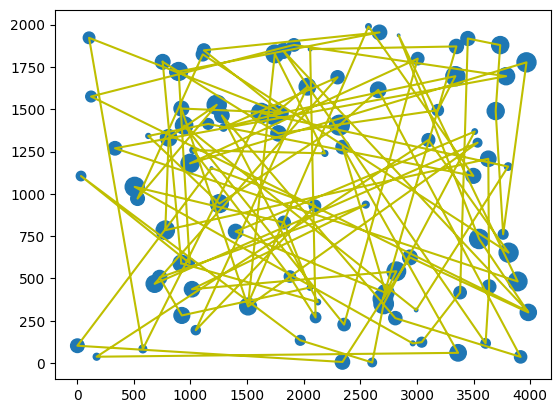

In [63]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 87679.135
MINIMUM (BEST): 84471
MAXIMUM (WORST): 95013


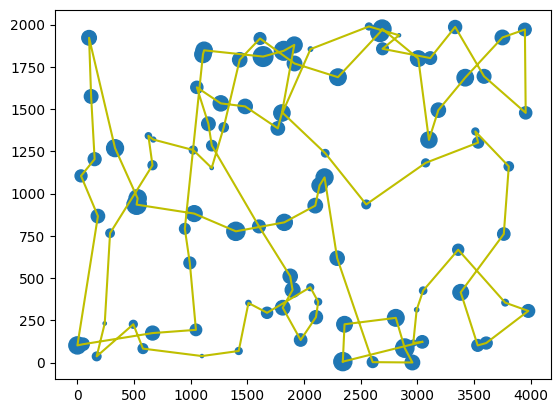

In [64]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 77239.11
MINIMUM (BEST): 75172
MAXIMUM (WORST): 80363


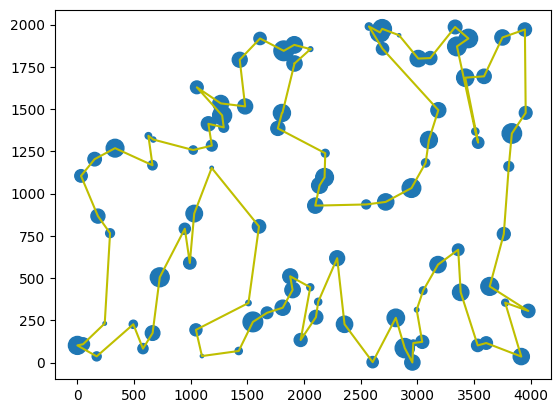

In [65]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 77239.11
MINIMUM (BEST): 75172
MAXIMUM (WORST): 80363


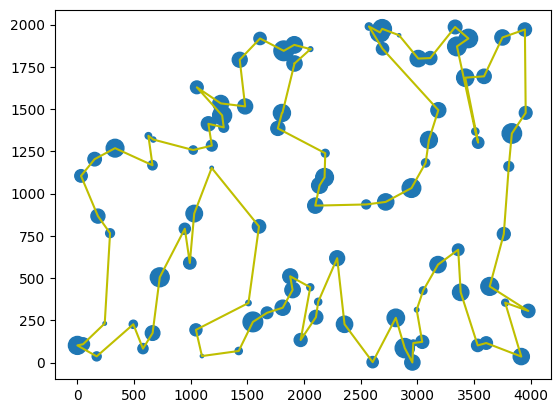

In [66]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

### Greedy cycle with and without jit

In [67]:
#greedy_cycle_jit()

In [68]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)

In [69]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hubra\AppData\Local\Temp\ipykernel_20508\658278868.py", line 1, in <module>
    get_ipython().run_cell_magic('timeit', '', 'mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)\n')
  File "C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2417, in run_cell_magic
    result = fn(*args, **kwargs)
  File "C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\magics\execution.py", line 1166, in timei

### Nearest Neighbour with and without jit

In [70]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)

14.9 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(nearest_neighbour, cost_matrix, 200)

618 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


=================================

In [ ]:
data = np.loadtxt('../data/TSPB.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 266350.235
MINIMUM (BEST): 242520
MAXIMUM (WORST): 296436


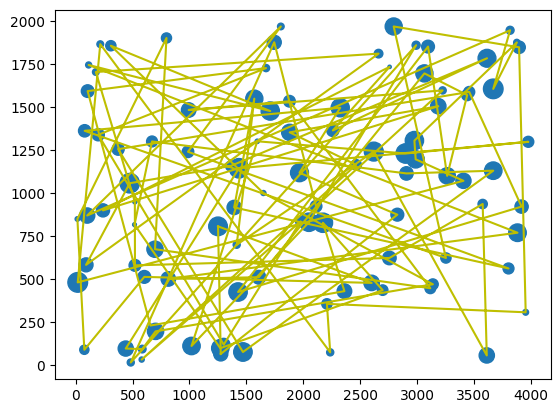

In [ ]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 79282.58
MINIMUM (BEST): 77448
MAXIMUM (WORST): 82631


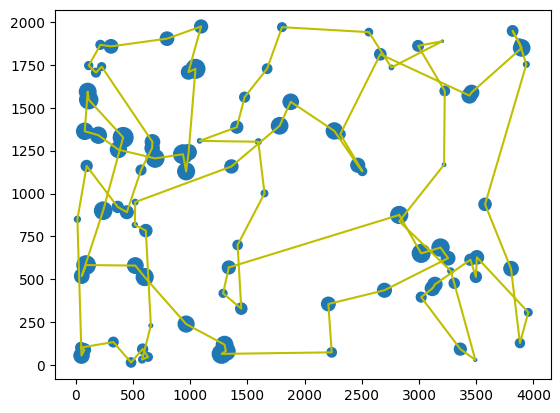

In [ ]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

NEAREST NEIGHBOR
AVERAGE: 79282.58
MINIMUM (BEST): 77448
MAXIMUM (WORST): 82631


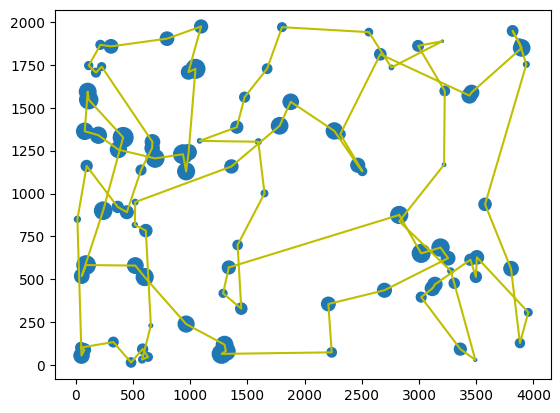

In [ ]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 70792.975
MINIMUM (BEST): 68743
MAXIMUM (WORST): 76568


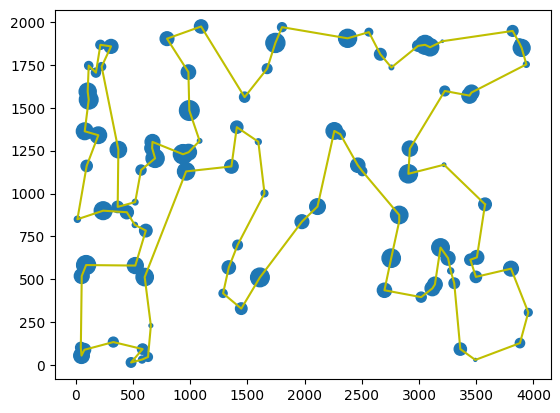

In [ ]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

GREEDY CYCLE
AVERAGE: 70792.975
MINIMUM (BEST): 68743
MAXIMUM (WORST): 76568


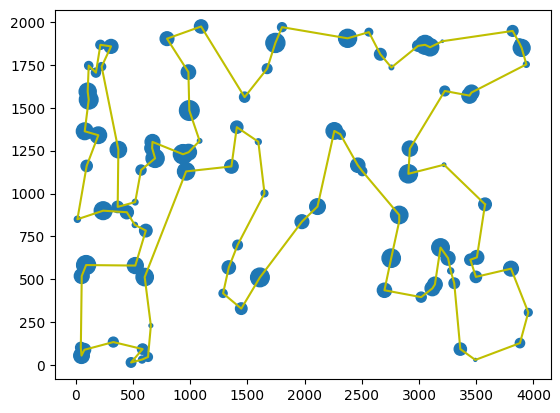

In [ ]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

Dataset C

In [71]:
data = np.loadtxt('../data/TSPC.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 214606.04
MINIMUM (BEST): 192204
MAXIMUM (WORST): 253609


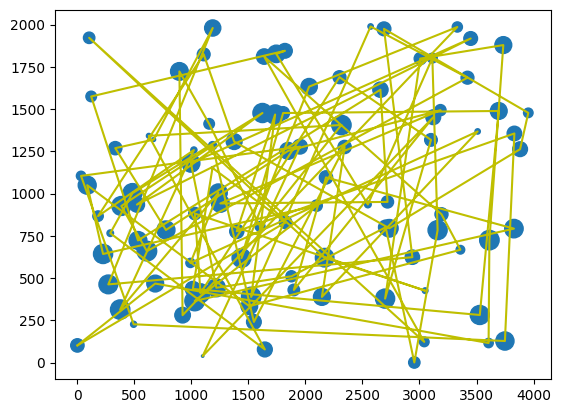

In [72]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 58872.68
MINIMUM (BEST): 56304
MAXIMUM (WORST): 63697


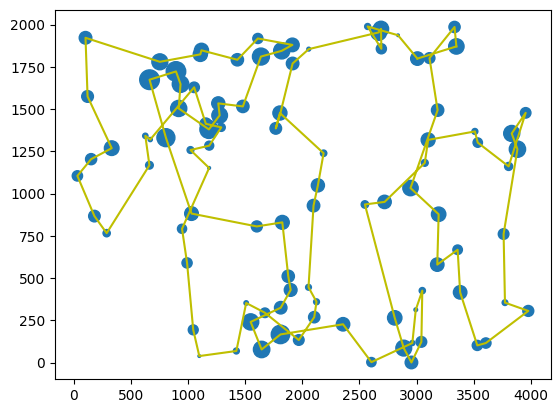

In [73]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 56045.035
MINIMUM (BEST): 53226
MAXIMUM (WORST): 59202


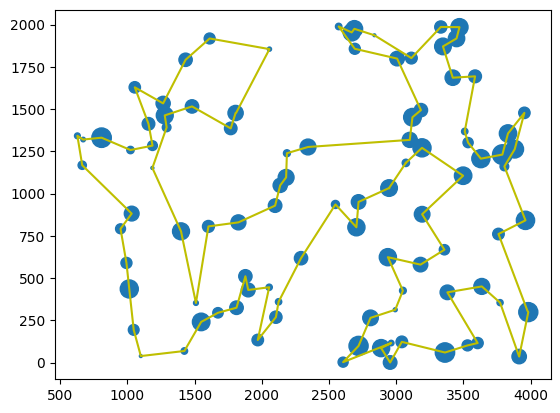

In [74]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)

Dataset D

In [75]:
data = np.loadtxt('../data/TSPD.csv', delimiter=';').astype(np.int16)
cost_matrix = create_cost_matrix(data)
cost_matrix.shape

(200, 200)

RANDOM SOLUTION
AVERAGE: 219392.845
MINIMUM (BEST): 188271
MAXIMUM (WORST): 245000


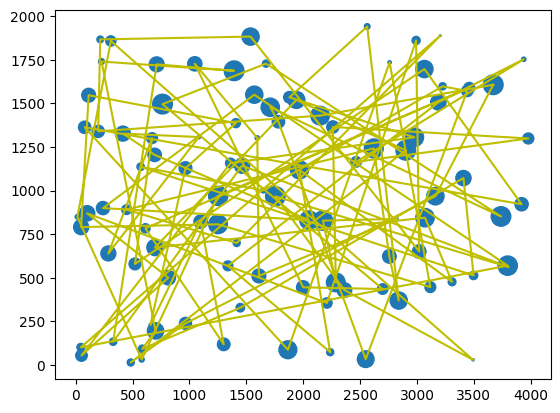

In [76]:
mean_obj_func_val, max_obj_func_value, min_obj_func_value, random_sol = test_random_solver(cost_matrix, 200)
print('RANDOM SOLUTION')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, random_sol)

NEAREST NEIGHBOR
AVERAGE: 54290.68
MINIMUM (BEST): 50335
MAXIMUM (WORST): 59846


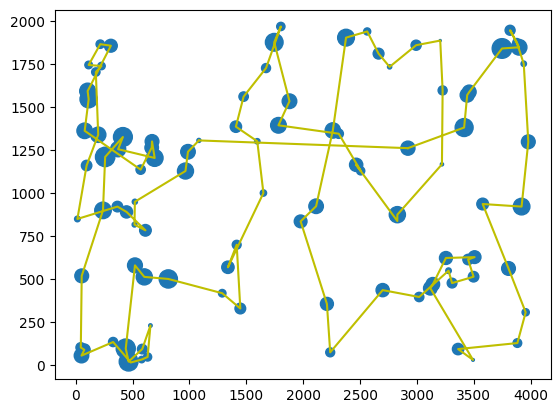

In [77]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, nearest_sol = test_solver(nearest_neighbour_jit, cost_matrix, 200)
print('NEAREST NEIGHBOR')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, nearest_sol)

GREEDY CYCLE
AVERAGE: 55008.055
MINIMUM (BEST): 50641
MAXIMUM (WORST): 60964


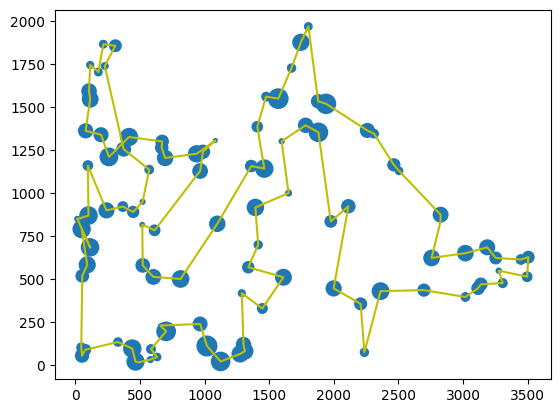

In [78]:
## jitted
mean_obj_func_val, max_obj_func_value, min_obj_func_value, greedy_sol = test_solver(greedy_cycle_jit, cost_matrix, 200)
print('GREEDY CYCLE')
print('AVERAGE:', mean_obj_func_val)
print('MINIMUM (BEST):', min_obj_func_value)
print('MAXIMUM (WORST):', max_obj_func_value)
plot(data, greedy_sol)